In [1]:
%matplotlib inline

In [19]:
from __future__ import print_function
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import IntSlider, HBox, interactive_output, Checkbox, Layout

from tomography import \
    read_data, \
    topo_phase_removal, \
    calculate_covariance_matrix, \
    capon_beam_forming_inversion

from tomography.ancillary import listfiles, normalize

inpath = 'E:/Dokumente/Skripte/python/PycharmProjects/tomography/data'
outpath = 'E:/Dokumente/Skripte/python/PycharmProjects/tomography/out'

# define the boxcar smoothing dimension
multi_look = 10

# define the max height for the inversion
height = 70


# next processing step
bla

In [3]:
if not os.path.exists(outpath):
    os.makedirs(outpath)

slc_list = listfiles(inpath, 'SLC_[0-9]_20151013_L_hv$')
phase_list = listfiles(inpath, 'Pha_[0-9]_20151013_L_hv$')
kz_list = listfiles(inpath, 'Kz_[0-9]_20151013_L_hv$')

In [4]:
# read SLC data
outname = os.path.join(outpath, 'SLC_stack')
SLC_stack = read_data(slc_list, outname)

# read files containing flat earth and topographical phase
outname = os.path.join(outpath, 'phase_stack')
phase_stack = read_data(phase_list, outname)

# read wavenumber files
outname = os.path.join(outpath, 'kz_stack')
kz_stack = read_data(kz_list, outname)

# remove flat earth and topographical phase
outname = os.path.join(outpath, 'normalized_stack')
normalized_stack = topo_phase_removal(SLC_stack, phase_stack, outname)

# compute covariance matrix
outname = os.path.join(outpath, 'cov_matrix')
covariance_matrix = calculate_covariance_matrix(normalized_stack, outname, multi_look)

# capon beam forming inversion
outname = os.path.join(outpath, 'capon_bf')
capon_bf = capon_beam_forming_inversion(covariance_matrix, kz_stack, outname, height)

# compute absolute values of the inversion result
capon_bf_abs = np.absolute(capon_bf)

In [7]:
# normalize the absolute beam forming inversion result per-pixel
caponnorm = np.apply_along_axis(normalize, 2, capon_bf)

<IPython.core.display.Javascript object>


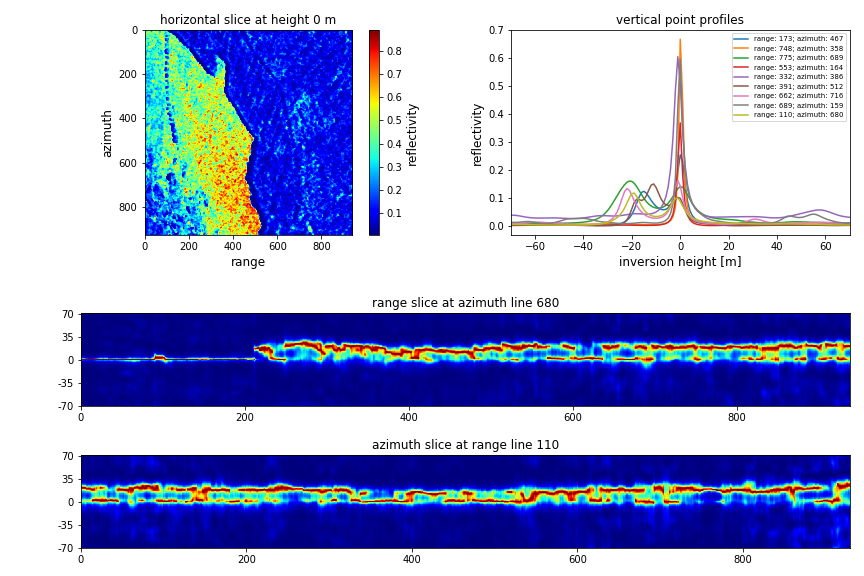

In [21]:
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (12, 8)

# height = capon_bf_abs.shape[2]//2

# define a sldier for changing a plotted image
slider = IntSlider(min=-height,max=height, step=10, continuous_update=False, 
                   description='inversion height', 
                   style = {'description_width': 'initial'})

# a simple checkbox to enable/disable stacking of vertical profiles into one plot
checkbox = Checkbox(value=True, description='stack vertical profiles')

# define some options for display of the widget box
layout = Layout(
    display='flex',
    flex_flow='row',
    border='solid 2px',
    align_items='stretch',
    width='88%'
)

# display the widget box
form = HBox([slider, checkbox], layout=layout)
display(form)

# set up subplot layout
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)
plt.subplots_adjust(left=0.1, right=0.2, top=0.3, bottom=0.2)

# edit the curser value format
ax1.format_coord = lambda x, y: 'x={0}, y={1}'.format(int(x), int(y))


# a function to respond to slider value changes
def f(h):
    p1 = ax1.imshow(capon_bf_abs[:, :, height+h], origin='upper', cmap='jet')
    ax1.set_xlabel('range', fontsize=12)
    ax1.set_ylabel('azimuth', fontsize=12)
    ax1.set_title('horizontal slice at height {} m'.format(h), fontsize=12)
    if len(ax1.images) > 1:
        ax1.images[0].colorbar.remove()
        del ax1.images[0]
    cbar = fig.colorbar(p1, ax=ax1)
    cbar.ax.set_ylabel('reflectivity', fontsize=12)#, rotation=270
    plt.show()


# enable interaction with the slider
out = interactive_output(f, {'h': slider})

# set up the plots for range and azimuth slices
ax3.set_xlim(0,capon_bf_abs.shape[1])
ax4.set_xlim(0,capon_bf_abs.shape[0])

# set up the y-axis ticks and labelling for the azimuth and range slice plots
ytick_lab = [-height, -height//2, 0, height//2, height]
ytick_pos = [0, height/2, height, height+height/2, height*2]
plt.setp([ax3, ax4], yticklabels=ytick_lab, yticks=ytick_pos)


# a function to respond to mouse clicks in the plot
def onclick(event):
    # only di something if the first plot has been clicked
    if event.inaxes == ax1:
        # retrieve the click coordinates and subset the ndarray accordingly
        x = int(event.xdata)
        y = int(event.ydata)
        subset_vertical = capon_bf_abs[x, y, :]
        label = 'range: {0:03}; azimuth: {1:03}'.format(x, y)

        # clear the plot in case stacking is disabled
        if not checkbox.value:
            ax2.cla()
        
        # set up the vertical profile plot
        ax2.set_xlabel('inversion height [m]', fontsize=12)
        ax2.set_ylabel('reflectivity', fontsize=12)
        ax2.set_title('vertical point profiles', fontsize=12)
        ax2.set_xlim(-height,height)

        # plot a vertical profile
        p2, = ax2.plot(range(-height,height+1), subset_vertical, label=label)
        ax2.legend(loc=0, prop={'size': 7}, markerscale=1)
        plt.show()

        # plot the range slice
        subset_range = caponnorm[x, :, :]
        p3 = ax3.imshow(np.rot90(subset_range, 1), origin='lower', cmap='jet', aspect='auto')
        ax3.set_title('range slice at azimuth line {}'.format(y), fontsize=12)
        plt.show()

        # plot the azimuth slice
        subset_azimuth = caponnorm[:, y, :]
        p4 = ax4.imshow(np.rot90(subset_azimuth, 1), origin='lower', cmap='jet', aspect='auto')
        ax4.set_title('azimuth slice at range line {}'.format(x), fontsize=12)
        plt.show()


# make the figure respond to mouse clicks by executing function onclick
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# arrange the subplots to make best use of space
plt.tight_layout()
plt.show()


#comparison different parameters
#map comparison
#comparison with SLC intensity (average)